In [2]:
from dataset import *
from train import *
from utils import torch_fix_seed

In [3]:
torch_fix_seed(19981303)

In [4]:
top_k_candidates = (20, 30, 40)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64

def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/CEM_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_pretrain_model():
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    base_encoder.load_state_dict(torch.load('../../GithubProject/cem-dataset/cem1.5m_swav_resnet50_200ep_balanced.pth.tar')['state_dict'])
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_model(keyword):
    if keyword == 'self_pretrained':
        return MoCo(get_self_pretrain_model(index=300), dim=512, K=k_value, T=temps, m=momentums, mlp=True, customized_model=True)
    if keyword == 'CEM':
        return MoCo(get_pretrain_model(), dim=512, K=k_value, T=temps, m=momentums, mlp=True, customized_model=True)
    if keyword == 'ImageNet':
        return MoCo(torchvision.models.resnet50, dim=512, K=k_value, T=temps, m=momentums, mlp=True, weights=ResNet50_Weights.IMAGENET1K_V2)
    if keyword == 'None':
        return MoCo(torchvision.models.resnet50, dim=512, K=k_value, T=temps, m=momentums, mlp=True, weights=None)

In [8]:
# parameters = {'pretrain_model': ['self_pretrained', 'CEM', 'ImageNet', 'None']}
parameters = {'pretrain_model': ['self_pretrained']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))

parameters = list(itertools.product(*parameters.values()))

for parameter in parameters:

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for images in k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

        model = get_model(pretrain_model)
        if pretrain_model in ['self_pretrained', 'CEM']:
            base_params = list(filter(lambda kv: 'fc' not in kv[0], model.encoder_q.named_parameters()))
            base_params = [v for k, v in base_params]
            fc_params = list(filter(lambda kv: 'fc' in kv[0], model.encoder_q.named_parameters()))
            fc_params = [v for k, v in fc_params]
            params = [{'params': base_params, 'lr': 3e-5}, {'params': fc_params, 'lr': 3e-3}]
        else:
            params = [{'params': model.parameters(), 'lr': 0.02}]
            
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(params=params, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        start_time = time.time()
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.9349328756332396, Val_loss 4.2175774574279785
Train_acc_top_20 0.1375	Train_acc_top_30 0.175	Train_acc_top_40 0.25	
Val_acc_top_20 0.0	Val_acc_top_30 0.04	Val_acc_top_40 0.12	
Epoch 2, Train_Loss 4.142886018753051, Val_loss 4.226586818695068
Train_acc_top_20 0.1187	Train_acc_top_30 0.1812	Train_acc_top_40 0.2375	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.04	
Epoch 3, Train_Loss 4.12275447845459, Val_loss 4.25150203704834
Train_acc_top_20 0.1313	Train_acc_top_30 0.1812	Train_acc_top_40 0.2375	
Val_acc_top_20 0.0	Val_acc_top_30 0.04	Val_acc_top_40 0.04	
Epoch 4, Train_Loss 4.093958902359009, Val_loss 4.190853595733643
Train_acc_top_20 0.1313	Train_acc_top_30 0.175	Train_acc_top_40 0.2188	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.0	
Epoch 5, Train_Loss 4.05347261428833, Val_loss 4.126172065734863
Train_acc_top_20 0.0813	Train_acc_top_30 0.1562	Train_acc_top_40 0.2062	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.04	
Epoch 6, Train

KeyboardInterrupt: 

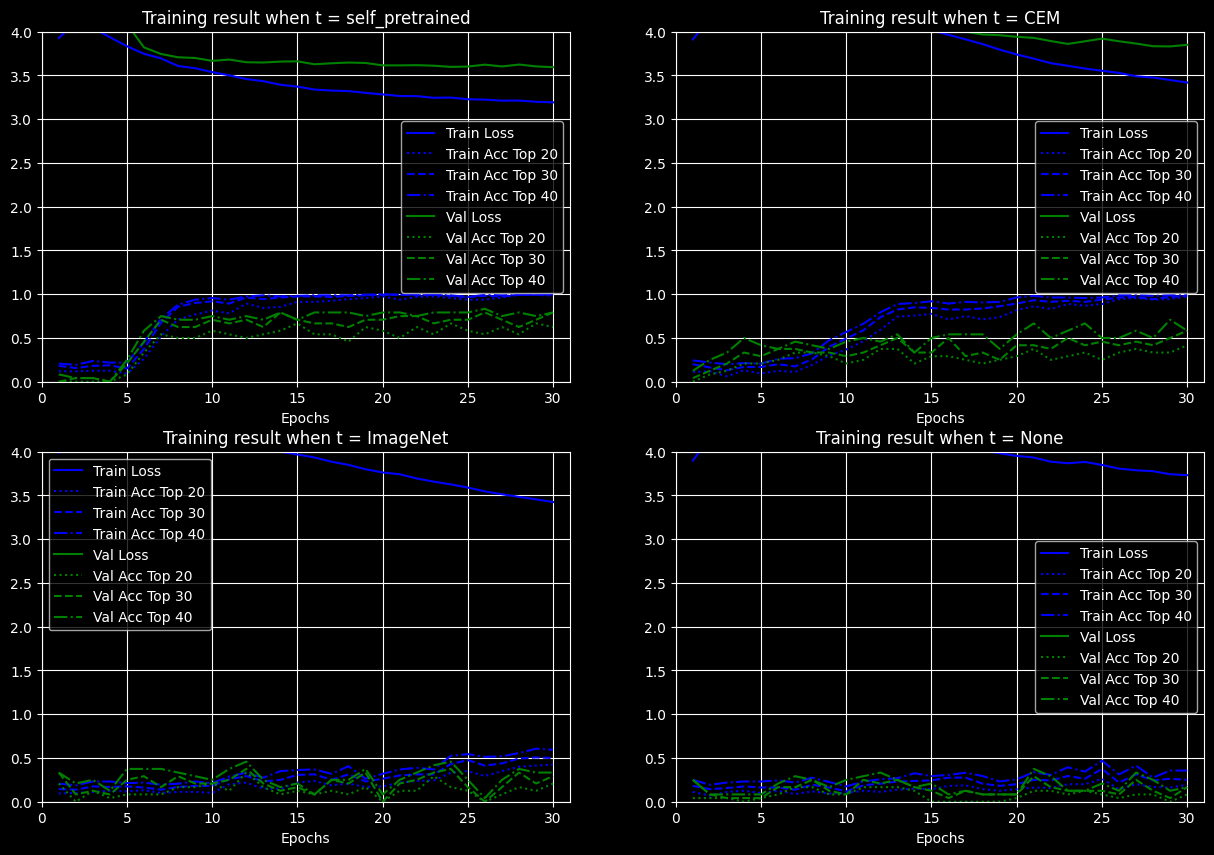

('self_pretrained',) 20 mean 0.5583333333333333
('self_pretrained',) 20 max 0.6666666666666666
('self_pretrained',) 30 mean 0.6874999999999999
('self_pretrained',) 30 max 0.7916666666666666
('self_pretrained',) 40 mean 0.7583333333333333
('self_pretrained',) 40 max 0.7916666666666666
('CEM',) 20 mean 0.2791666666666667
('CEM',) 20 max 0.375
('CEM',) 30 mean 0.3708333333333333
('CEM',) 30 max 0.5
('CEM',) 40 mean 0.4875
('CEM',) 40 max 0.5416666666666666
('ImageNet',) 20 mean 0.12916666666666668
('ImageNet',) 20 max 0.3333333333333333
('ImageNet',) 30 mean 0.2
('ImageNet',) 30 max 0.375
('ImageNet',) 40 mean 0.25000000000000006
('ImageNet',) 40 max 0.4583333333333333
('None',) 20 mean 0.06666666666666667
('None',) 20 max 0.16666666666666666
('None',) 30 mean 0.14166666666666666
('None',) 30 max 0.25
('None',) 40 mean 0.1708333333333333
('None',) 40 max 0.3333333333333333


<Figure size 640x480 with 0 Axes>

In [38]:
draw_graph(train_metrics.data, 30, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][:20][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1][:20])}')

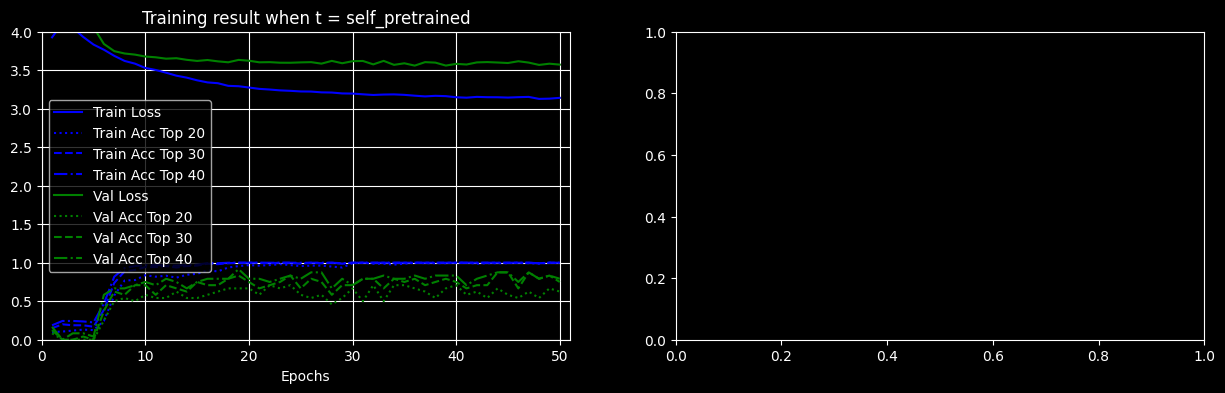

('self_pretrained',) 20 mean 0.6166666666666666
('self_pretrained',) 20 max 0.7083333333333334
('self_pretrained',) 30 mean 0.7666666666666666
('self_pretrained',) 30 max 0.875
('self_pretrained',) 40 mean 0.8125
('self_pretrained',) 40 max 0.9166666666666666


<Figure size 640x480 with 0 Axes>

In [33]:
draw_graph(train_metrics.data, 50, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

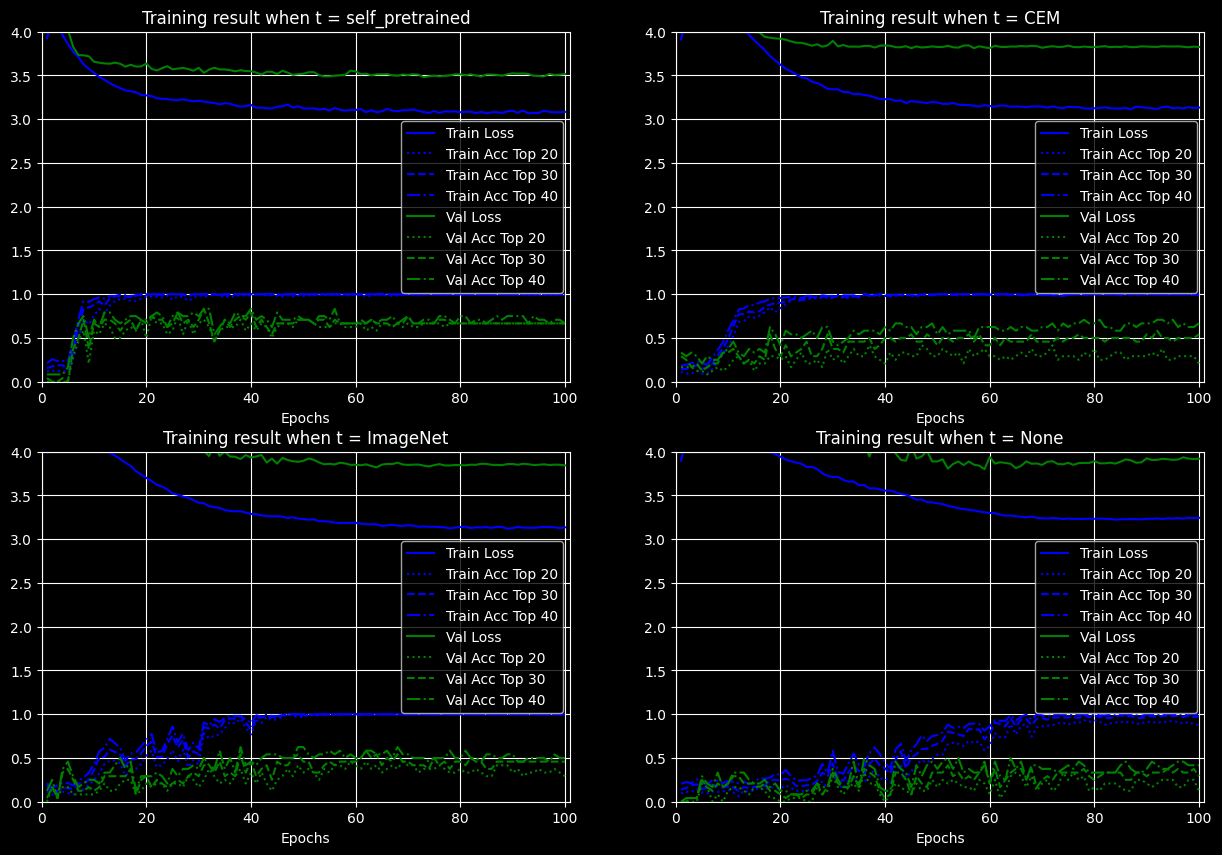

('self_pretrained',) 20 mean 0.6666666666666665
('self_pretrained',) 20 max 0.75
('self_pretrained',) 30 mean 0.6666666666666665
('self_pretrained',) 30 max 0.8333333333333334
('self_pretrained',) 40 mean 0.7125
('self_pretrained',) 40 max 0.8333333333333334
('CEM',) 20 mean 0.2875
('CEM',) 20 max 0.4166666666666667
('CEM',) 30 mean 0.5
('CEM',) 30 max 0.5833333333333334
('CEM',) 40 mean 0.6541666666666666
('CEM',) 40 max 0.7083333333333334
('ImageNet',) 20 mean 0.3458333333333333
('ImageNet',) 20 max 0.4583333333333333
('ImageNet',) 30 mean 0.45
('ImageNet',) 30 max 0.5833333333333334
('ImageNet',) 40 mean 0.50625
('ImageNet',) 40 max 0.625
('None',) 20 mean 0.19791666666666669
('None',) 20 max 0.3333333333333333
('None',) 30 mean 0.32499999999999996
('None',) 30 max 0.4166666666666667
('None',) 40 mean 0.3916666666666667
('None',) 40 max 0.5


<Figure size 640x480 with 0 Axes>

In [8]:
# self-pretrained 800

draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-20:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

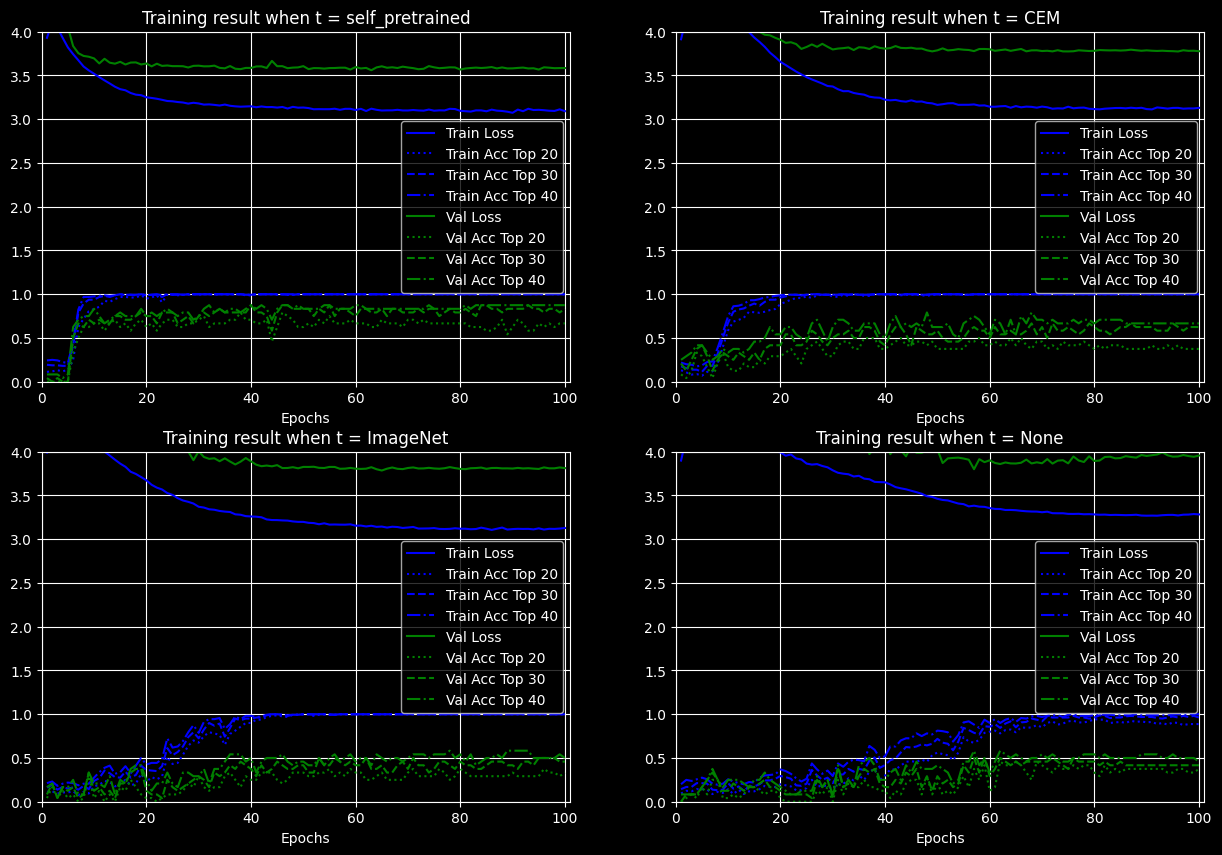

('self_pretrained',) 20 mean 0.6333333333333333
('self_pretrained',) 20 max 0.7916666666666666
('self_pretrained',) 30 mean 0.8270833333333334
('self_pretrained',) 30 max 0.875
('self_pretrained',) 40 mean 0.8729166666666668
('self_pretrained',) 40 max 0.875
('CEM',) 20 mean 0.38958333333333334
('CEM',) 20 max 0.5
('CEM',) 30 mean 0.6104166666666667
('CEM',) 30 max 0.6666666666666666
('CEM',) 40 mean 0.6770833333333333
('CEM',) 40 max 0.7916666666666666
('ImageNet',) 20 mean 0.30625
('ImageNet',) 20 max 0.375
('ImageNet',) 30 mean 0.4416666666666667
('ImageNet',) 30 max 0.5
('ImageNet',) 40 mean 0.51875
('ImageNet',) 40 max 0.5833333333333334
('None',) 20 mean 0.36041666666666666
('None',) 20 max 0.4583333333333333
('None',) 30 mean 0.4208333333333333
('None',) 30 max 0.5
('None',) 40 mean 0.5104166666666667
('None',) 40 max 0.5833333333333334


<Figure size 640x480 with 0 Axes>

In [8]:
# self-pretrained 300

draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-20:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

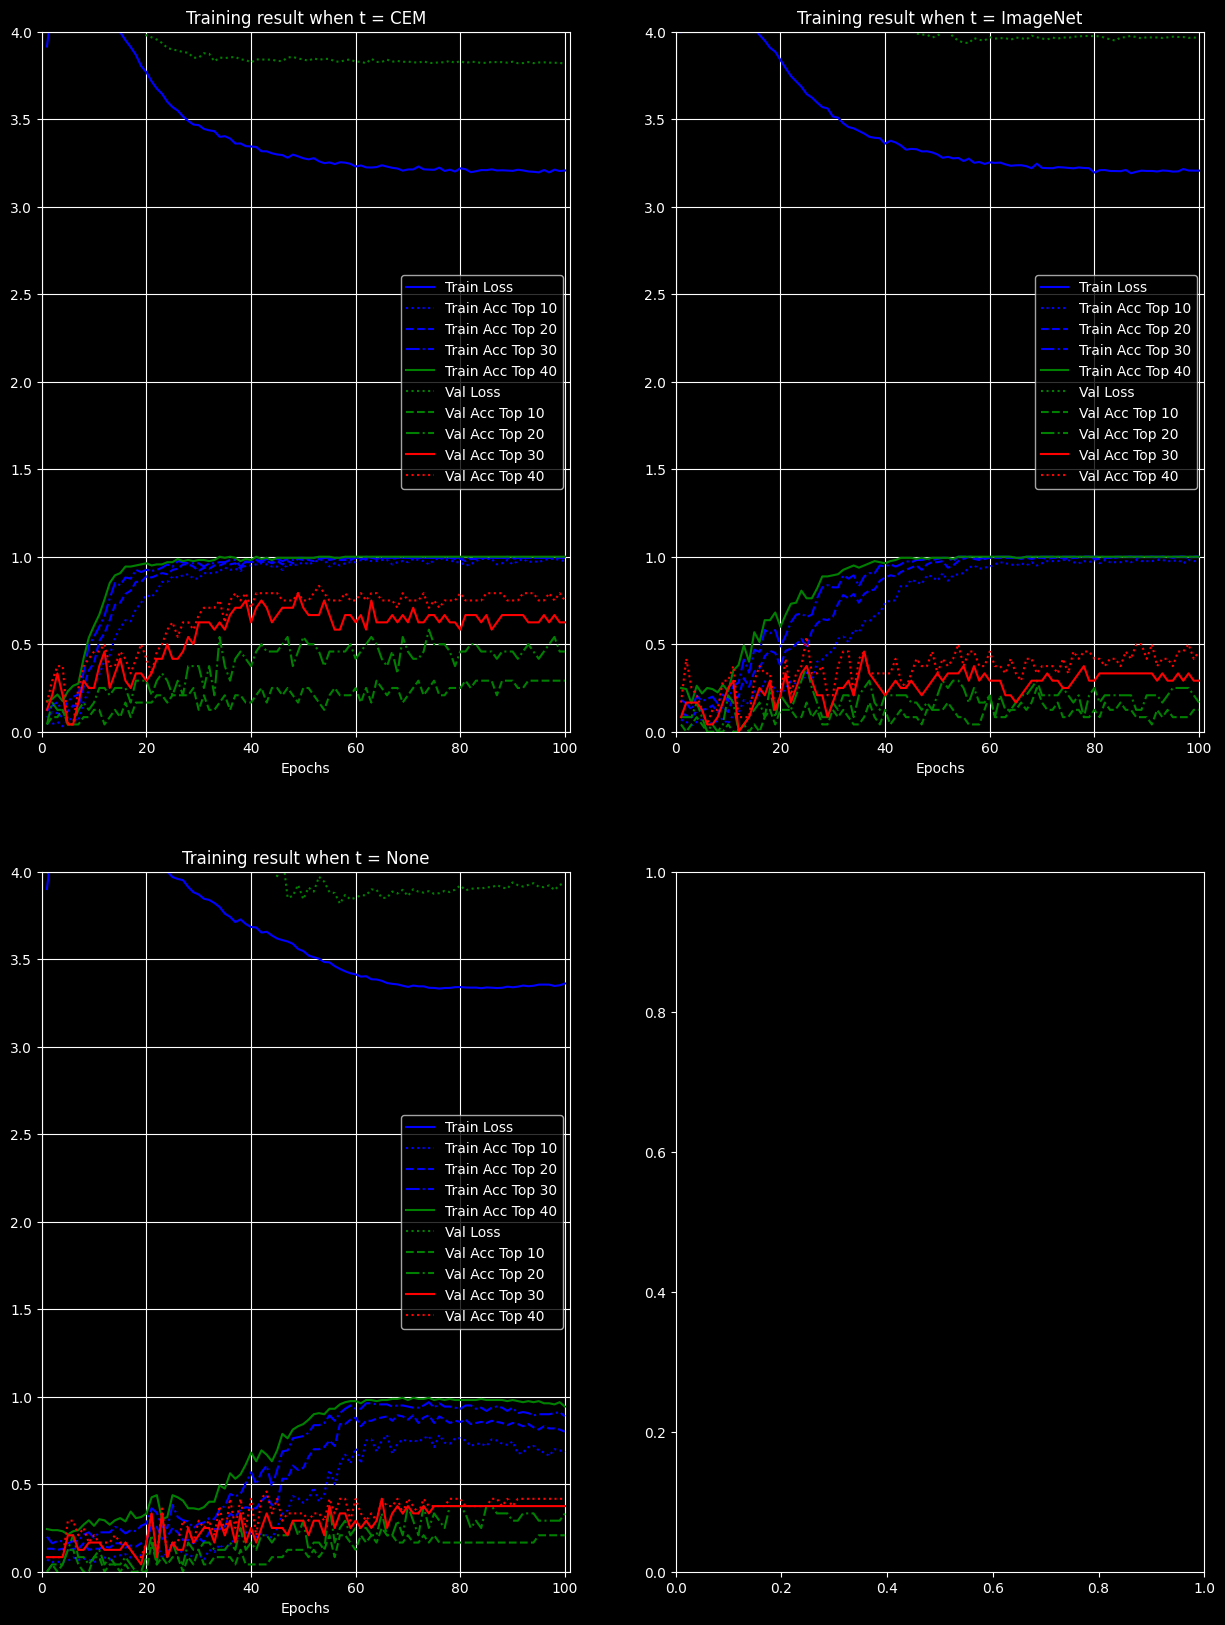

('CEM',) 10 mean 0.2833333333333333
('CEM',) 10 max 0.2916666666666667
('CEM',) 20 mean 0.4666666666666666
('CEM',) 20 max 0.5833333333333334
('CEM',) 30 mean 0.6416666666666666
('CEM',) 30 max 0.7916666666666666
('CEM',) 40 mean 0.7708333333333333
('CEM',) 40 max 0.8333333333333334
('ImageNet',) 10 mean 0.09583333333333333
('ImageNet',) 10 max 0.25
('ImageNet',) 20 mean 0.21666666666666665
('ImageNet',) 20 max 0.375
('ImageNet',) 30 mean 0.3083333333333333
('ImageNet',) 30 max 0.4583333333333333
('ImageNet',) 40 mean 0.4375
('ImageNet',) 40 max 0.5416666666666666
('None',) 10 mean 0.19166666666666665
('None',) 10 max 0.25
('None',) 20 mean 0.3083333333333333
('None',) 20 max 0.375
('None',) 30 mean 0.375
('None',) 30 max 0.4166666666666667
('None',) 40 mean 0.4166666666666667
('None',) 40 max 0.4583333333333333


<Figure size 640x480 with 0 Axes>

In [4]:
draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

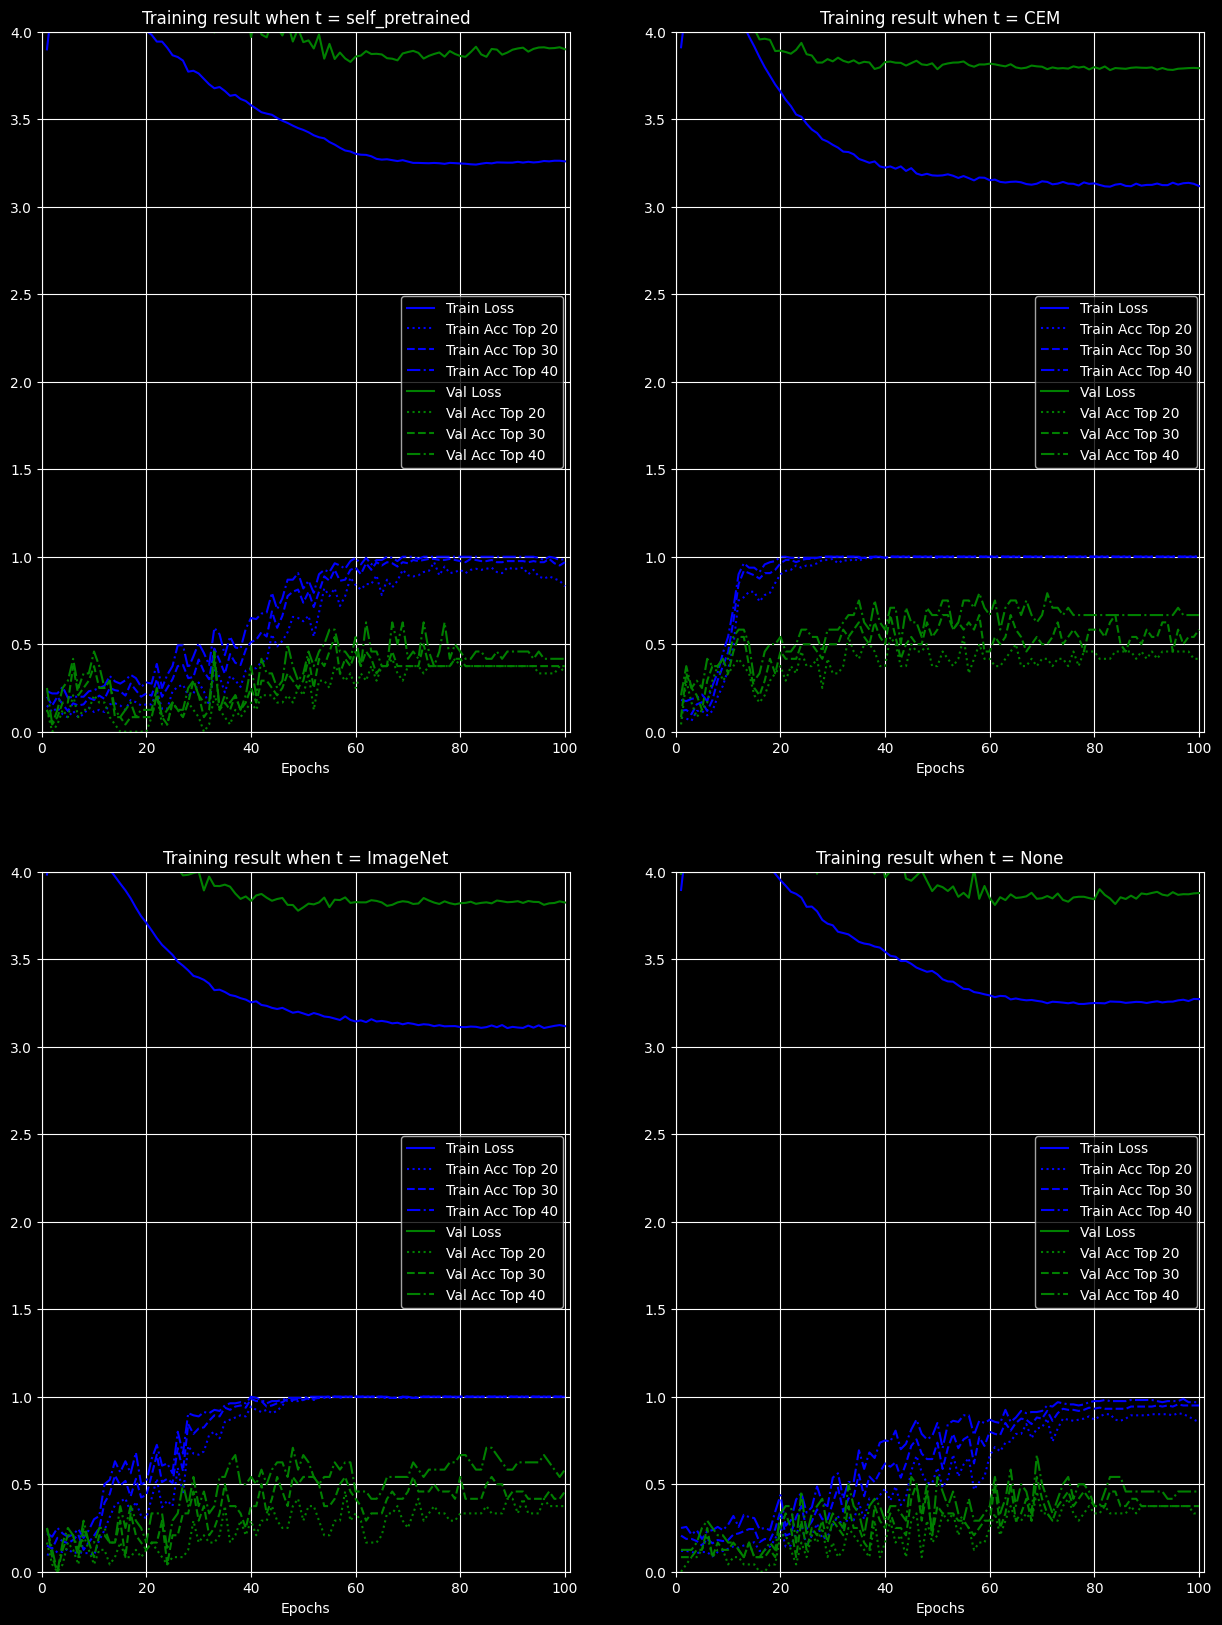

('self_pretrained',) 20 mean 0.35416666666666663
('self_pretrained',) 20 max 0.4166666666666667
('self_pretrained',) 30 mean 0.375
('self_pretrained',) 30 max 0.5416666666666666
('self_pretrained',) 40 mean 0.4333333333333333
('self_pretrained',) 40 max 0.625
('CEM',) 20 mean 0.4458333333333334
('CEM',) 20 max 0.5416666666666666
('CEM',) 30 mean 0.5541666666666666
('CEM',) 30 max 0.6666666666666666
('CEM',) 40 mean 0.6708333333333334
('CEM',) 40 max 0.7916666666666666
('ImageNet',) 20 mean 0.36666666666666664
('ImageNet',) 20 max 0.4583333333333333
('ImageNet',) 30 mean 0.4333333333333333
('ImageNet',) 30 max 0.5416666666666666
('ImageNet',) 40 mean 0.6125
('ImageNet',) 40 max 0.7083333333333334
('None',) 20 mean 0.3666666666666667
('None',) 20 max 0.4583333333333333
('None',) 30 mean 0.375
('None',) 30 max 0.5416666666666666
('None',) 40 mean 0.4499999999999999
('None',) 40 max 0.6666666666666666


<Figure size 640x480 with 0 Axes>

In [6]:
draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')

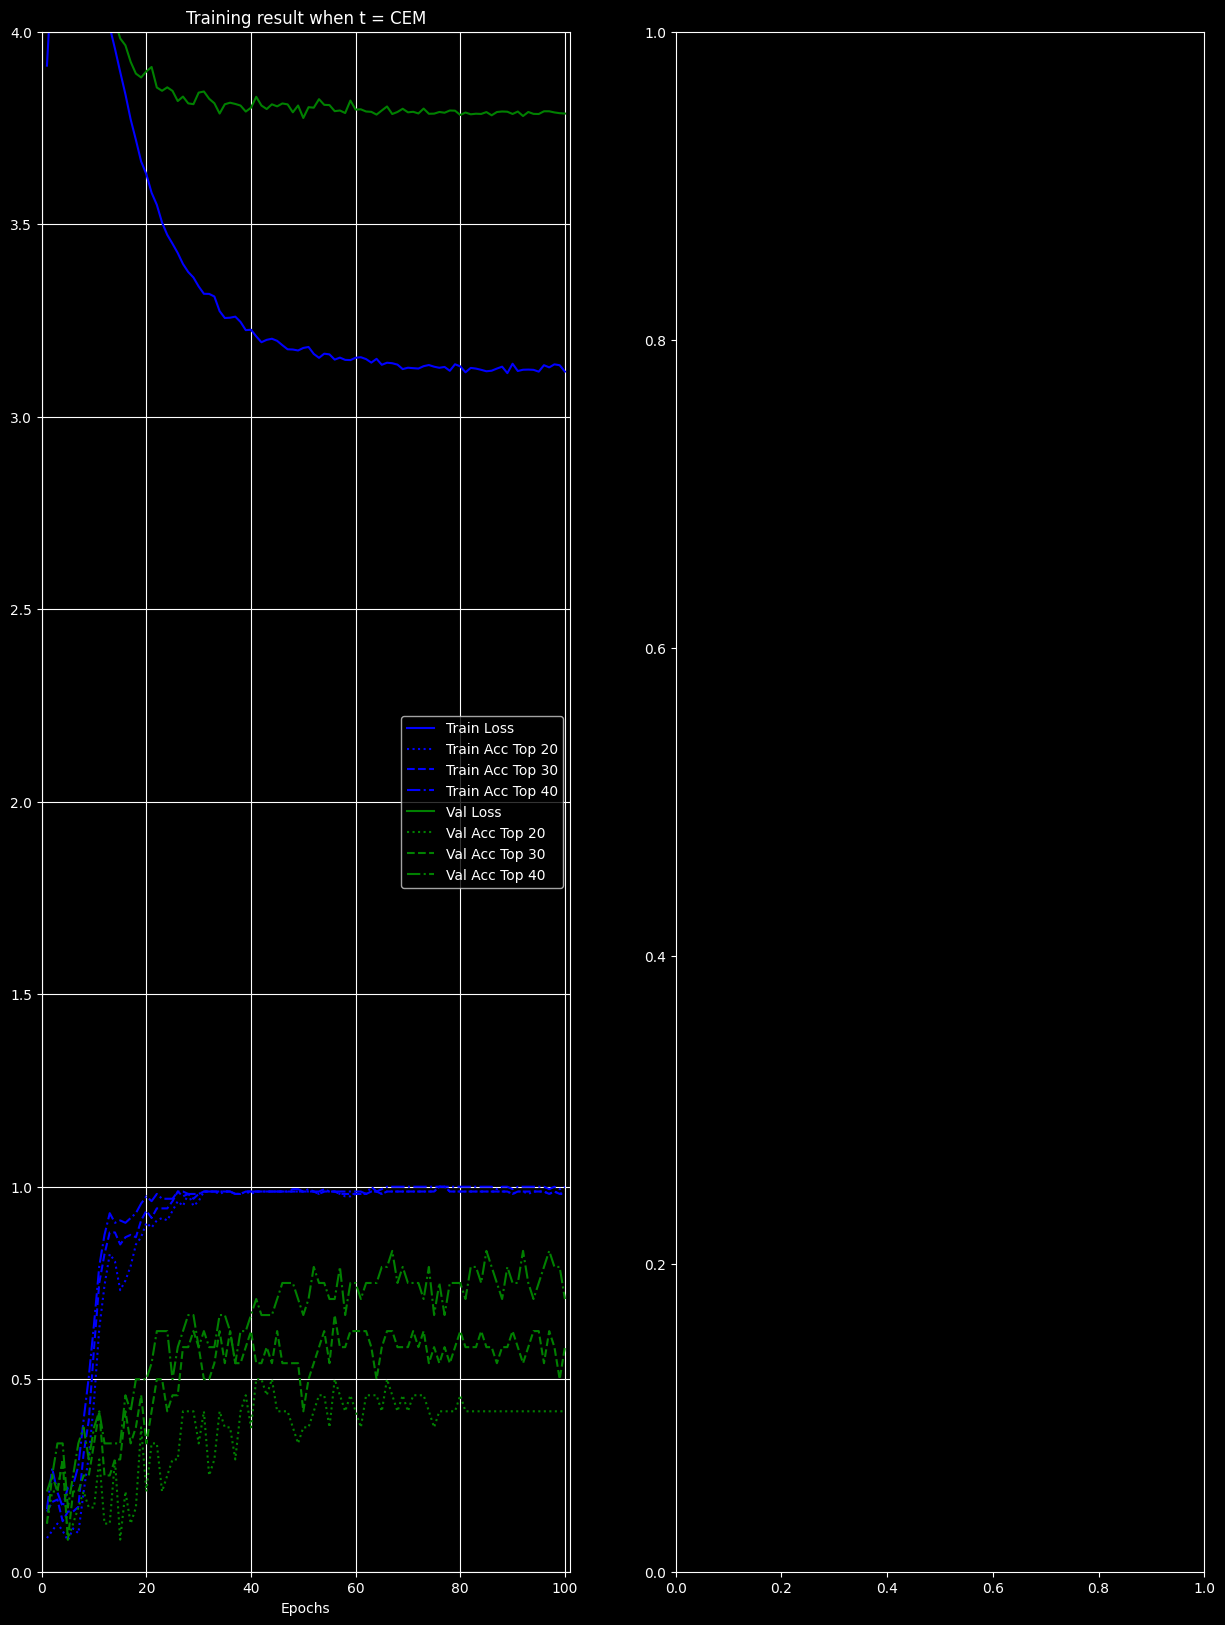

('CEM',) 20 mean 0.4166666666666667
('CEM',) 20 max 0.5
('CEM',) 30 mean 0.5791666666666667
('CEM',) 30 max 0.6666666666666666
('CEM',) 40 mean 0.7708333333333334
('CEM',) 40 max 0.8333333333333334


<Figure size 640x480 with 0 Axes>

In [5]:
# 19981303

draw_graph(train_metrics.data, 100, ('tok_ks'))
for k, v in train_metrics.data.items():
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')